## Exploration_19_cGAN
1. 데이터 처리
2. Augmentation
3. 모델 설정
4. 모델 학습
5. 회고

### GAN vs. cGAN (conditonal GAN)
#### [GAN] : Label 이 없다
![](https://d3s0tskafalll9.cloudfront.net/media/images/gan_img.max-800x600.png)

#### [cGAN] : Label 정보가 같이 들어간다 (Label 에 해당하는 이미지 형성)
![](https://d3s0tskafalll9.cloudfront.net/media/images/cgan_img.max-800x600.png)

### pix2pix (pixel to pixel)
- 간단한 이미지(sketch)를 입력 받아 실제 이미지와 비슷한 형태로 출력하는 GAN의 종류

### 1. 데이터 처리
#### 데이터 불러오기

In [79]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of train examples :", len(os.listdir(data_path)))
print("number of val examples :", len(os.listdir(test_path)))

number of train examples : 1000
number of val examples : 5


- Train, val에 이미지가 몇개 씩 있는지 확인

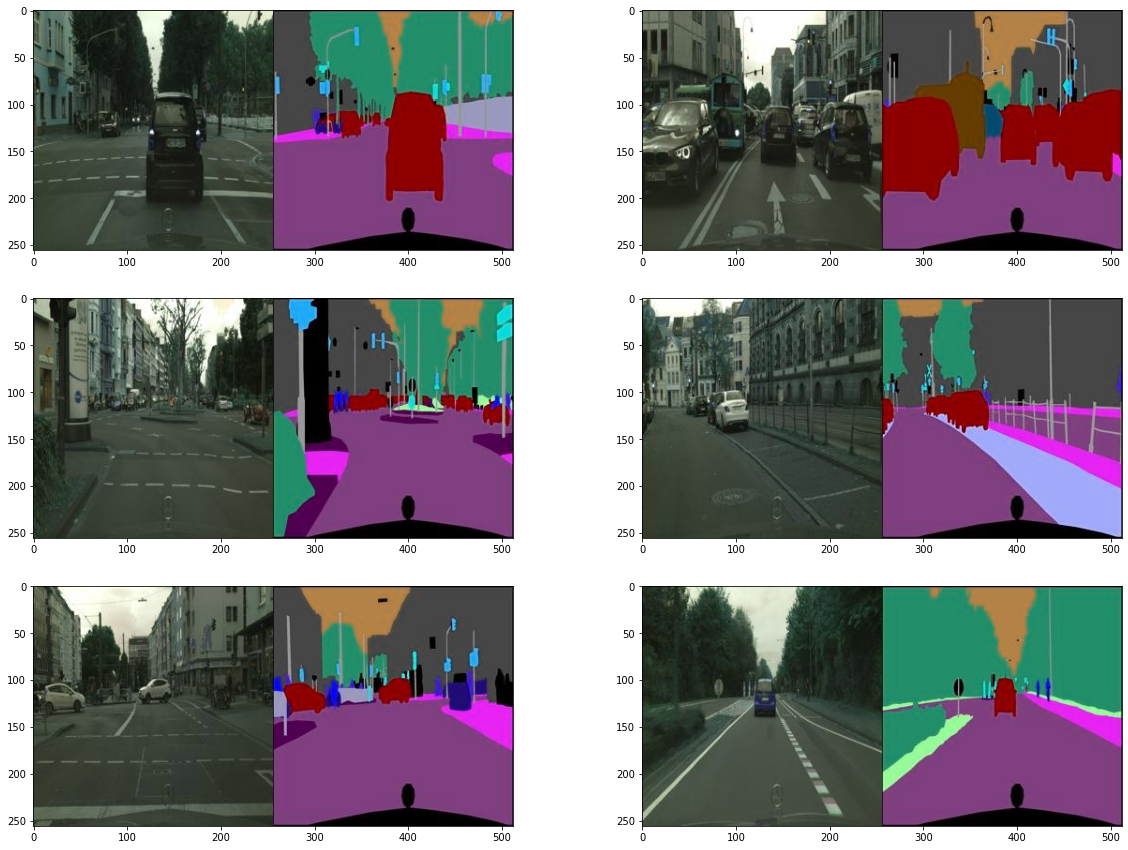

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(999)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [81]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* 실제 이미지와 sketch 이미지를 출력해 보고, 이미지의 크기도 확인 해 본다.

#### Image 분리

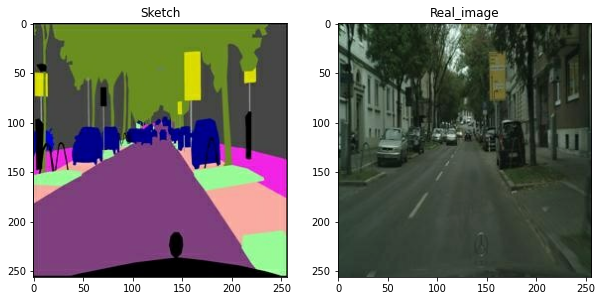

In [82]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Sketch")
plt.imshow(denormalize(sketch))
plt.subplot(1,2,2)
plt.title("Real_image")
plt.imshow(denormalize(colored))

* Sketch 이미지와 실제 이미지를 따로 분리하여 출력

### 2. Augmentation
- 상하좌우 반전을 통해 다양한 형태의 이미지를 만들어 학습에 사용한다.

In [83]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

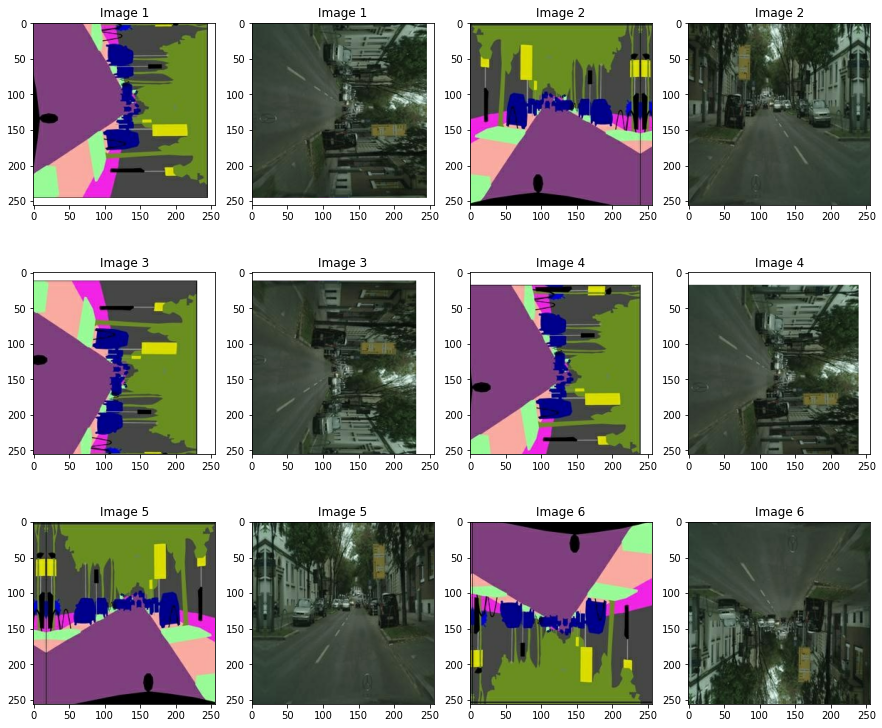

In [84]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

* 출력 된 이미지 처럼 상하좌우 반전이미지들을 함께 학습시켜 학습력을 높힌다.

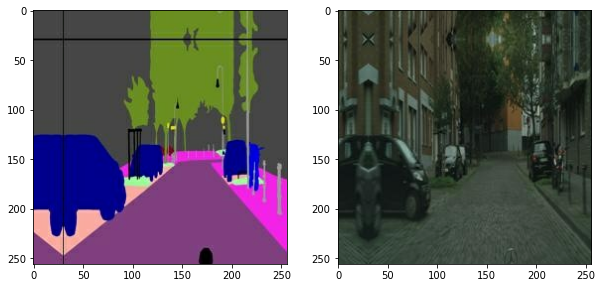

In [85]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### 3. 모델설정
#### Encoder 설정

In [86]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [87]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [88]:
Encoder().get_summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_96 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_97 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_98 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_99 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_100 (EncodeBloc (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_101 (EncodeBloc (None, 4, 4, 512)         419

#### Decoder 설정

In [89]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [90]:
Decoder().get_summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_84 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_85 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_86 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_87 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_88 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_89 (DecodeBlock (None, 64, 64, 128)       524

In [91]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_7 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_7 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [92]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

#### UNetGenerator 설정
* U 형태의 network 이다.
* Input data가 학습되어가면서 대칭되는 Output network에 계속적으로 정보를 전달 해 줌으로써 좀 더 명확한 이미지를 생성 할 수 있도록 도와준다.
![](https://miro.medium.com/max/700/1*f7YOaE4TWubwaFF7Z1fzNw.png)<br><br>
* Encoder-decoder 만 사용 했을 때와, UNet을 사용 했을 때 아래와 같이 이미지의 선명도에서 상당한 차이가 나는 것을 알 수 있다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g.max-800x600.png)

In [93]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [94]:
UNetGenerator().get_summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_112 (EncodeBlock)  (None, 128, 128, 64) 3072        input_25[0][0]                   
__________________________________________________________________________________________________
encode_block_113 (EncodeBlock)  (None, 64, 64, 128)  131584      encode_block_112[0][0]           
__________________________________________________________________________________________________
encode_block_114 (EncodeBlock)  (None, 32, 32, 256)  525312      encode_block_113[0][0]           
___________________________________________________________________________________________

In [95]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [96]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_255 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_159 (LeakyReLU)  (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [97]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [98]:
Discriminator().get_summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_58 (Concatenate)    (None, 256, 256, 6)  0           input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
disc_block_45 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_58[0][0]      

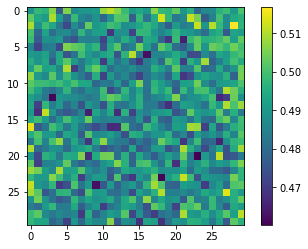

In [99]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [100]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [101]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [102]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

### 4. 모델학습
#### EPOCHS 설정
- 일단 LMS에서 제안한 10으로 설정한 뒤 결과를 확인 해 본다.

In [77]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9045                     
L1_loss:0.3380                     
Discriminator_loss:1.2828

EPOCH[1] - STEP[20]                     
Generator_loss:0.8152                     
L1_loss:0.2583                     
Discriminator_loss:1.3340

EPOCH[1] - STEP[30]                     
Generator_loss:0.6941                     
L1_loss:0.1870                     
Discriminator_loss:1.3279

EPOCH[1] - STEP[40]                     
Generator_loss:0.9852                     
L1_loss:0.2037                     
Discriminator_loss:1.3991

EPOCH[1] - STEP[50]                     
Generator_loss:0.8507                     
L1_loss:0.2101                     
Discriminator_loss:1.1991

EPOCH[1] - STEP[60]                     
Generator_loss:0.9853                     
L1_loss:0.1822                     
Discriminator_loss:1.2154

EPOCH[1] - STEP[70]                     
Generator_loss:0.7437                     
L1_loss:0.2179                    

#### Test 이미지 확인
- Test 이미지 중에 하나를 가져와 제대로 작동하는지 확인 해 본다.

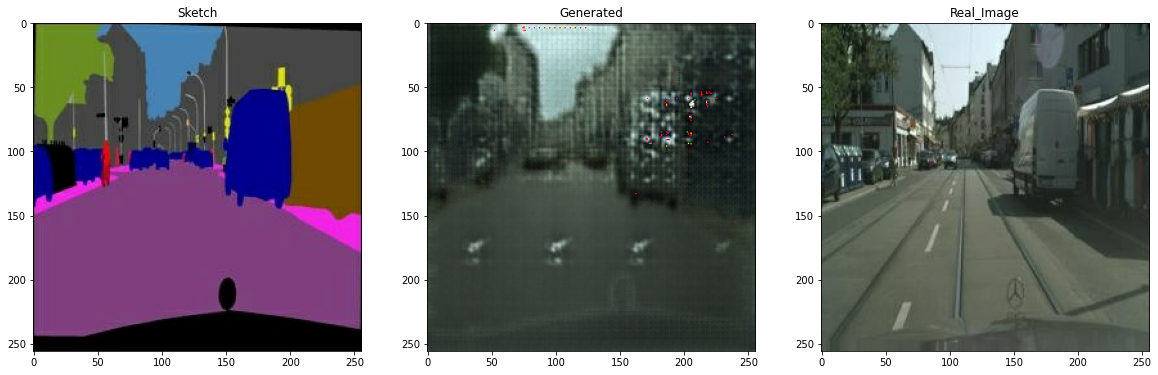

In [78]:
test_ind = 1

# validation set 에서 data를 가져온다
f = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Sketch")
plt.imshow(denormalize(sketch))
plt.subplot(1,3,2)
plt.title("Generated")
plt.imshow(pred[0])
plt.subplot(1,3,3)
plt.title("Real_Image")
plt.imshow(denormalize(colored))

* 10 epochs를 실행 했을 때 결과를 보면 가운데 'Generated'이미지가 오른쪽의 실제이미지인 'Real_image' 이미지와 조금은 비슷하게 만들어 지는 것 처럼 보이지만 여전히 이미지가 명확하지 않고 일부 부정확한 것을 알 수 있다.
* 그리고 loss를 보면 generator loss 값이 0.8, discriminator loss값이 0.8인 것을 알 수 있다. 따라서 Generator loss를 1.0에 가깝게, 그리고 discriminator loss 를 0.5에 가깝게 나오도록 좀 더 학습을 시켜 보도록 하겠다.

#### Epochs : 10 -> 50
* 10 EPOCHS 는 역시나 부족하다고 생각이 들어 50으로 실행 해 보기로 한다.

In [103]:
EPOCHS = 50 

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9632                     
L1_loss:0.2840                     
Discriminator_loss:1.1751

EPOCH[1] - STEP[20]                     
Generator_loss:0.9015                     
L1_loss:0.2899                     
Discriminator_loss:1.5287

EPOCH[1] - STEP[30]                     
Generator_loss:0.9450                     
L1_loss:0.2272                     
Discriminator_loss:1.3094

EPOCH[1] - STEP[40]                     
Generator_loss:1.0795                     
L1_loss:0.2019                     
Discriminator_loss:1.2727

EPOCH[1] - STEP[50]                     
Generator_loss:0.6235                     
L1_loss:0.1953                     
Discriminator_loss:1.3763

EPOCH[1] - STEP[60]                     
Generator_loss:0.9453                     
L1_loss:0.1848                     
Discriminator_loss:1.0946

EPOCH[1] - STEP[70]                     
Generator_loss:0.9207                     
L1_loss:0.2054                    

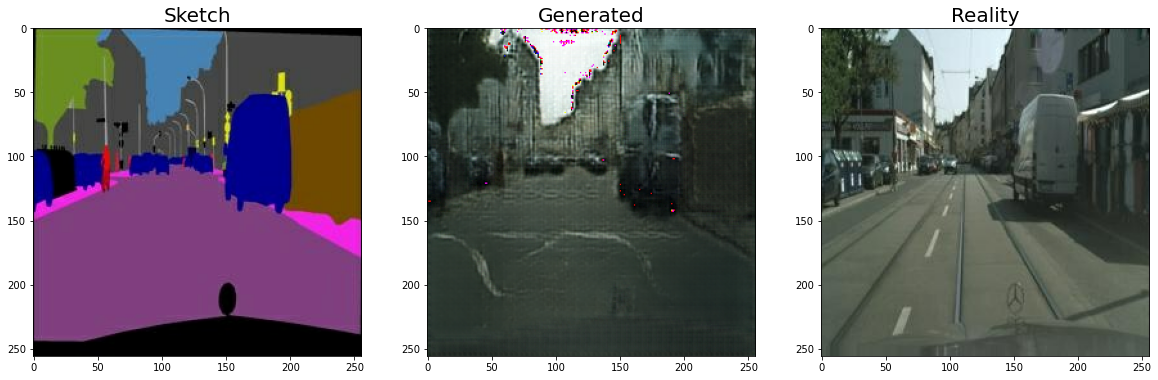

In [104]:
test_ind = 1

# validation set 에서 data를 가져온다
f = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Sketch", fontsize=20)
plt.imshow(denormalize(sketch))
plt.subplot(1,3,2)
plt.title("Generated", fontsize=20)
plt.imshow(pred[0])
plt.subplot(1,3,3)
plt.title("Reality", fontsize=20)
plt.imshow(denormalize(colored))

* EPOCHS 50정도로 테스트를 해보니 확실히 이미지가 선명해 진 것이 보인다.
* Reality 이미지와 거의 비슷한 수준으로 만들기 위해서는 200 EPOCHS 정도로 학습을 진행하면 얼추 가능하지 않을까 하는 생각이든다.

### 5. 회고

* 이번에는 GAN 중에 하나인 conditonal GAN에 대한 내용이었다.
* 일반 GAN과는 달리 학습에 label을 추가해주어 좀 더 정확한 내용을 학습하도록 하는 방식이라고 볼 수 있다.
* UNetGenerator도 비슷한 방식이라고 생각하면 그 원리를 좀 더 쉽게 이해할 수 있었다.
* Sketch를 이용해 실제와 비슷한 이미지를 만들어 내는 기술은 단순히 생각해 봐도 정말 많은 곳에 사용 될 수 있어보인다. 새로운 형태의 디자인 개발, 범인의 몽타주, 사진 복원 등 간단한 스케치로 특징만 잡아주면 나머지는 GAN을 통해 만들어 낼 수가 있을 것이다.
* 한정 된 데이터의 양으로 모델을 학습시켜야 하는 경우에는 역시 augmentation을 이용해 학습량을 늘리는 것이 꽤나 유용하다는 것 또한 다시 한 번 확인 할 수 있었다.
* 앞으로 GAN 기술이 점점 발전함에 따라 변해 갈 우리의 일상이 많이 기대된다.